In [1]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


Get MNIST

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]][0:1000]
x_test_38 = x_test[idx_test[3]+idx_test[8]][0:200]


# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
y_test_38 = y_test[idx_test[3]+idx_test[8]][0:200]


In [3]:
# K-Means clustering to find centers
_38 = []
for i in [3,8]:
    kmeans_model = KMeans(10)
    kmeans_model.fit(x_train[idx_train[i]])
    _38.extend(kmeans_model.cluster_centers_)

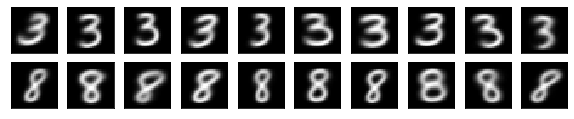

In [4]:
# plot cluster centers as images
fig = plt.figure(figsize = (10,10))

for i in range(20):
  subplot = fig.add_subplot(10, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i]*255, (28, 28)), cmap='gray')
  

In [6]:

class Model:
    
    def __init__(self):
        self.m_centers = []
        self.unit = None
        self.row = None
        self.col = None
        self.x = None
        
        self.m_train_image = []
        self.m_test_image = []
        self.m_train_label = []
        self.m_test_label = []
        
        self.temp1 = None
        self.temp2 = None
        self.model = None
        
    def _Segmentation(self,unit,centers):
        self.unit = unit
        self.row = random.randrange(0,29-self.unit)
        self.col = random.randrange(0,29-self.unit)
        
        for center in centers:
            self.m_centers.extend(center[r*28+self.col : r*28+(self.col+self.unit) ] for r in range(self.row,self.row+self.unit))
        self.m_centers = np.reshape(self.m_centers,(-1,self.unit*self.unit))   
        
        self.x = np.zeros((len(centers),len(centers)))
        for i in range(len(centers)):
            self.x[i][i] = 1
        
    def _fit(self,train_image,test_image,train_label,test_label):
        
        for arr in train_image:
            self.m_train_image.extend(arr[r*28+self.col : r*28+(self.col+self.unit) ] 
                                      for r in range(self.row,self.row+self.unit))
        self.m_train_image = np.reshape(self.m_train_image,(-1,self.unit*self.unit))
        
        for arr in test_image:
            self.m_test_image.extend(arr[r*28+self.col : r*28+(self.col+self.unit) ] 
                                      for r in range(self.row,self.row+self.unit))          
        self.m_test_image = np.reshape(self.m_test_image,(-1,self.unit*self.unit))
        
        for arr in train_label:    
            self.m_train_label.extend(arr)
        self.m_train_label = np.reshape(self.m_train_label,(-1,10))
    
        
        for arr in test_label:    
            self.m_test_label.extend(arr)
        self.m_test_label = np.reshape(self.m_test_label,(-1,10))
            
    
    def _RBF(self):
        # RBF Layer
        kernel = PairwiseKernel(metric='polynomial') 
        rbf_model = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(self.m_centers,self.x)

        self.temp1 = rbf_model.predict(self.m_train_image)
        self.temp2 = rbf_model.predict(self.m_test_image)


    def _Perceptron(self):
        # Perceptron Layers
        batch_size = 128
        epochs = 100

        self.model = Sequential()
        self.model.add(Dense(10, activation='softmax', input_shape=(len(self.m_centers),)))
        

        self.model.summary()
        nadam=keras.optimizers.Nadam(lr=0.0005)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=nadam,
                      metrics=['accuracy'])


        # Train model
        history = self.model.fit(self.temp1, self.m_train_label,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
    def _Predict(self):
        predictions = self.model.predict(self.temp2)

        return predictions

    
    
def get_accuracy(softmax_sum,test_label):
    true=0
    for i in range(len(softmax_sum)):
        if np.argmax(softmax_sum[i])==np.argmax(test_label[i]):
            true +=1
    print("Accuracy : ", true/len(softmax_sum))

In [7]:
models = [Model() for i in range(50)]
softmax_sum = np.ones((len(x_test_38),10))
for m in models:
    m._Segmentation(7,_38)
#     m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
#     m._RBF()
#     m._Perceptron()
#     softmax_sum += m._Predict()

In [8]:
get_accuracy(softmax_sum,y_test_38)

Accuracy :  0.86


In [15]:
models = [Model() for i in range(50)]
softmax_sum = np.ones((len(x_test_38),10))
for m in models:
    m._Segmentation(14,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 2.2973 - acc: 0.1220
Epoch 2/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.2855 - acc: 0.1310
Epoch 3/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.2729 - acc: 0.1380
Epoch 4/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.2599 - acc: 0.1480
Epoch 5/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.2466 - acc: 0.1540
Epoch 6/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.2334 - acc: 0.1590
Epoch 7/100
1000/1000 [==============================] - 0s 26us/step - loss: 2

1000/1000 [==============================] - 0s 27us/step - loss: 1.4511 - acc: 0.7860
Epoch 79/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4424 - acc: 0.7910
Epoch 80/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4338 - acc: 0.7960
Epoch 81/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4253 - acc: 0.8010
Epoch 82/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4168 - acc: 0.8020
Epoch 83/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4084 - acc: 0.8070
Epoch 84/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.4001 - acc: 0.8160
Epoch 85/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.3917 - acc: 0.8200
Epoch 86/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.3835 - acc: 0.8250
Epoch 87/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.3753 - acc: 0.8270
Epoch 88/100


1000/1000 [==============================] - 0s 24us/step - loss: 2.0522 - acc: 0.4080
Epoch 32/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0402 - acc: 0.4180
Epoch 33/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0282 - acc: 0.4250
Epoch 34/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.0162 - acc: 0.4290
Epoch 35/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0044 - acc: 0.4330
Epoch 36/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9927 - acc: 0.4380
Epoch 37/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9810 - acc: 0.4450
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9692 - acc: 0.4540
Epoch 39/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9578 - acc: 0.4620
Epoch 40/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9461 - acc: 0.4660
Epoch 41/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.4022 - acc: 0.7560
Epoch 91/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3941 - acc: 0.7610
Epoch 92/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3861 - acc: 0.7660
Epoch 93/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3780 - acc: 0.7730
Epoch 94/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3701 - acc: 0.7770
Epoch 95/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3622 - acc: 0.7790
Epoch 96/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3544 - acc: 0.7800
Epoch 97/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3466 - acc: 0.7860
Epoch 98/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3389 - acc: 0.7870
Epoch 99/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3312 - acc: 0.7890
Epoch 100/100

1000/1000 [==============================] - 0s 21us/step - loss: 1.8549 - acc: 0.5240
Epoch 45/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8438 - acc: 0.5320
Epoch 46/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8326 - acc: 0.5400
Epoch 47/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8216 - acc: 0.5480
Epoch 48/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8106 - acc: 0.5540
Epoch 49/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7998 - acc: 0.5610
Epoch 50/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7889 - acc: 0.5650
Epoch 51/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7781 - acc: 0.5710
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7675 - acc: 0.5740
Epoch 53/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7568 - acc: 0.5780
Epoch 54/100


Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 2.4952 - acc: 0.1360
Epoch 2/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4817 - acc: 0.1440
Epoch 3/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4673 - acc: 0.1520
Epoch 4/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4524 - acc: 0.1570
Epoch 5/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4374 - acc: 0.1660
Epoch 6/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4225 - acc: 0.1720
Epoch 7/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4075 - acc: 0.1820
Epoch 8/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3927 - acc: 0.1870
Epoch 9/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.3780 - acc: 0.1960
Epoch 10/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.3633 - acc: 0.2040
Epoch 11/1

1000/1000 [==============================] - 0s 26us/step - loss: 1.5444 - acc: 0.6020
Epoch 84/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.5358 - acc: 0.6060
Epoch 85/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5274 - acc: 0.6100
Epoch 86/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.5190 - acc: 0.6110
Epoch 87/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5106 - acc: 0.6160
Epoch 88/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5023 - acc: 0.6210
Epoch 89/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4941 - acc: 0.6210
Epoch 90/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4859 - acc: 0.6260
Epoch 91/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4778 - acc: 0.6300
Epoch 92/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4697 - acc: 0.6310
Epoch 93/100


1000/1000 [==============================] - 0s 23us/step - loss: 2.0037 - acc: 0.3380
Epoch 38/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9919 - acc: 0.3530
Epoch 39/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9802 - acc: 0.3580
Epoch 40/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9685 - acc: 0.3680
Epoch 41/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9569 - acc: 0.3740
Epoch 42/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9455 - acc: 0.3780
Epoch 43/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9341 - acc: 0.3880
Epoch 44/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9228 - acc: 0.3960
Epoch 45/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9115 - acc: 0.4100
Epoch 46/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9004 - acc: 0.4220
Epoch 47/100


1000/1000 [==============================] - 0s 24us/step - loss: 1.3780 - acc: 0.6990
Epoch 97/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3703 - acc: 0.7060
Epoch 98/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3628 - acc: 0.7080
Epoch 99/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.3553 - acc: 0.7090
Epoch 100/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3478 - acc: 0.7150
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 2.5898 - acc: 0.0660
Epoch 2/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.5747 -

1000/1000 [==============================] - 0s 24us/step - loss: 1.8628 - acc: 0.4860
Epoch 51/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8517 - acc: 0.4960
Epoch 52/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.8407 - acc: 0.5020
Epoch 53/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8299 - acc: 0.5050
Epoch 54/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8190 - acc: 0.5140
Epoch 55/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8082 - acc: 0.5210
Epoch 56/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7975 - acc: 0.5310
Epoch 57/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7868 - acc: 0.5360
Epoch 58/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7762 - acc: 0.5400
Epoch 59/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7657 - acc: 0.5420
Epoch 60/100


1000/1000 [==============================] - 0s 25us/step - loss: 2.4932 - acc: 0.1210
Epoch 5/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4771 - acc: 0.1280
Epoch 6/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4610 - acc: 0.1300
Epoch 7/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4450 - acc: 0.1340
Epoch 8/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4293 - acc: 0.1420
Epoch 9/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4135 - acc: 0.1510
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.3980 - acc: 0.1590
Epoch 11/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.3826 - acc: 0.1650
Epoch 12/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3675 - acc: 0.1720
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3524 - acc: 0.1760
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 24us/step - loss: 1.5322 - acc: 0.6170
Epoch 87/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5238 - acc: 0.6230
Epoch 88/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.5154 - acc: 0.6250
Epoch 89/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.5072 - acc: 0.6300
Epoch 90/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4990 - acc: 0.6330
Epoch 91/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4908 - acc: 0.6350
Epoch 92/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4828 - acc: 0.6400
Epoch 93/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4747 - acc: 0.6450
Epoch 94/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4667 - acc: 0.6510
Epoch 95/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4588 - acc: 0.6520
Epoch 96/100


1000/1000 [==============================] - 0s 24us/step - loss: 1.9509 - acc: 0.3980
Epoch 41/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9389 - acc: 0.4120
Epoch 42/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9269 - acc: 0.4170
Epoch 43/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.9151 - acc: 0.4240
Epoch 44/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9034 - acc: 0.4310
Epoch 45/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8918 - acc: 0.4370
Epoch 46/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8802 - acc: 0.4480
Epoch 47/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8687 - acc: 0.4630
Epoch 48/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8573 - acc: 0.4700
Epoch 49/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8460 - acc: 0.4810
Epoch 50/100


1000/1000 [==============================] - 0s 24us/step - loss: 1.3607 - acc: 0.7770
Epoch 99/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.3527 - acc: 0.7820
Epoch 100/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3448 - acc: 0.7900
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 2.5732 - acc: 0.0580
Epoch 2/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.5596 - acc: 0.0630
Epoch 3/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.5452 - acc: 0.0690
Epoch 4/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.5302 - a

1000/1000 [==============================] - 0s 25us/step - loss: 1.8187 - acc: 0.4920
Epoch 53/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8077 - acc: 0.4960
Epoch 54/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7969 - acc: 0.5020
Epoch 55/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7860 - acc: 0.5090
Epoch 56/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7754 - acc: 0.5130
Epoch 57/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7647 - acc: 0.5210
Epoch 58/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7542 - acc: 0.5260
Epoch 59/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.7437 - acc: 0.5300
Epoch 60/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7333 - acc: 0.5380
Epoch 61/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7230 - acc: 0.5440
Epoch 62/100


1000/1000 [==============================] - 0s 25us/step - loss: 2.1125 - acc: 0.2000
Epoch 7/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.0993 - acc: 0.2150
Epoch 8/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.0861 - acc: 0.2260
Epoch 9/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0731 - acc: 0.2370
Epoch 10/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0601 - acc: 0.2520
Epoch 11/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0472 - acc: 0.2620
Epoch 12/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.0344 - acc: 0.2740
Epoch 13/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.0218 - acc: 0.2870
Epoch 14/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0091 - acc: 0.3090
Epoch 15/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.9966 - acc: 0.3250
Epoch 16/100
100

1000/1000 [==============================] - 0s 25us/step - loss: 1.2896 - acc: 0.8610
Epoch 89/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2823 - acc: 0.8620
Epoch 90/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.2750 - acc: 0.8640
Epoch 91/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.2679 - acc: 0.8660
Epoch 92/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2607 - acc: 0.8680
Epoch 93/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2537 - acc: 0.8690
Epoch 94/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.2467 - acc: 0.8690
Epoch 95/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2397 - acc: 0.8700
Epoch 96/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2328 - acc: 0.8710
Epoch 97/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2260 - acc: 0.8710
Epoch 98/100


1000/1000 [==============================] - 0s 25us/step - loss: 1.8640 - acc: 0.5190
Epoch 43/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8527 - acc: 0.5280
Epoch 44/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8415 - acc: 0.5420
Epoch 45/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8303 - acc: 0.5520
Epoch 46/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8192 - acc: 0.5610
Epoch 47/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8082 - acc: 0.5760
Epoch 48/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7972 - acc: 0.5900
Epoch 49/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7863 - acc: 0.5980
Epoch 50/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7755 - acc: 0.6070
Epoch 51/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7647 - acc: 0.6180
Epoch 52/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.2543 - acc: 0.6490
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 2.3845 - acc: 0.0720
Epoch 2/100
1000/1000 [==============================] - 0s 27us/step - loss: 2.3710 - acc: 0.0790
Epoch 3/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3565 - acc: 0.0840
Epoch 4/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3415 - acc: 0.0990
Epoch 5/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3263 - acc: 0.1080
Epoch 6/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3111 - acc:

1000/1000 [==============================] - 0s 23us/step - loss: 1.7596 - acc: 0.5900
Epoch 55/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7490 - acc: 0.5940
Epoch 56/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7386 - acc: 0.5970
Epoch 57/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.7281 - acc: 0.6010
Epoch 58/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7179 - acc: 0.6050
Epoch 59/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7076 - acc: 0.6130
Epoch 60/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6974 - acc: 0.6170
Epoch 61/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.6873 - acc: 0.6230
Epoch 62/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.6773 - acc: 0.6270
Epoch 63/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.6672 - acc: 0.6360
Epoch 64/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.2148 - acc: 0.2070
Epoch 9/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.2016 - acc: 0.2220
Epoch 10/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1884 - acc: 0.2350
Epoch 11/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1753 - acc: 0.2380
Epoch 12/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1624 - acc: 0.2520
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1494 - acc: 0.2640
Epoch 14/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1365 - acc: 0.2730
Epoch 15/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.1236 - acc: 0.2930
Epoch 16/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.1109 - acc: 0.3020
Epoch 17/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.0982 - acc: 0.3110
Epoch 18/100
1

1000/1000 [==============================] - 0s 24us/step - loss: 1.3503 - acc: 0.8260
Epoch 91/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3424 - acc: 0.8290
Epoch 92/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3346 - acc: 0.8300
Epoch 93/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.3268 - acc: 0.8320
Epoch 94/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.3191 - acc: 0.8330
Epoch 95/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3114 - acc: 0.8360
Epoch 96/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.3038 - acc: 0.8370
Epoch 97/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2962 - acc: 0.8390
Epoch 98/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2887 - acc: 0.8410
Epoch 99/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2812 - acc: 0.8420
Epoch 100/100

1000/1000 [==============================] - 0s 25us/step - loss: 1.9331 - acc: 0.4750
Epoch 45/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9218 - acc: 0.4790
Epoch 46/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.9105 - acc: 0.4850
Epoch 47/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8992 - acc: 0.4980
Epoch 48/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8880 - acc: 0.5050
Epoch 49/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8770 - acc: 0.5090
Epoch 50/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8659 - acc: 0.5150
Epoch 51/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8549 - acc: 0.5180
Epoch 52/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8439 - acc: 0.5260
Epoch 53/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8331 - acc: 0.5340
Epoch 54/100


Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 2.4924 - acc: 0.0450
Epoch 2/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4792 - acc: 0.0450
Epoch 3/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4651 - acc: 0.0490
Epoch 4/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.4505 - acc: 0.0530
Epoch 5/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4357 - acc: 0.0560
Epoch 6/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.4210 - acc: 0.0570
Epoch 7/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.4062 - acc: 0.0650
Epoch 8/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.3916 - acc: 0.0710
Epoch 9/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3770 - acc: 0.0780
Epoch 10/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.3626 - acc: 0.0840
Epoch 11/1

1000/1000 [==============================] - 0s 24us/step - loss: 1.5182 - acc: 0.6990
Epoch 84/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.5093 - acc: 0.7040
Epoch 85/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.5004 - acc: 0.7090
Epoch 86/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4916 - acc: 0.7130
Epoch 87/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4828 - acc: 0.7180
Epoch 88/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4741 - acc: 0.7240
Epoch 89/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4654 - acc: 0.7300
Epoch 90/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4568 - acc: 0.7350
Epoch 91/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4483 - acc: 0.7410
Epoch 92/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4398 - acc: 0.7430
Epoch 93/100


1000/1000 [==============================] - 0s 23us/step - loss: 1.9276 - acc: 0.4690
Epoch 38/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.9160 - acc: 0.4720
Epoch 39/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.9044 - acc: 0.4750
Epoch 40/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8930 - acc: 0.4780
Epoch 41/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8817 - acc: 0.4820
Epoch 42/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.8705 - acc: 0.4890
Epoch 43/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8593 - acc: 0.4930
Epoch 44/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8482 - acc: 0.5000
Epoch 45/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.8373 - acc: 0.5000
Epoch 46/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8264 - acc: 0.5080
Epoch 47/100


1000/1000 [==============================] - 0s 24us/step - loss: 1.3040 - acc: 0.7890
Epoch 97/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.2964 - acc: 0.7910
Epoch 98/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2888 - acc: 0.7940
Epoch 99/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2812 - acc: 0.7960
Epoch 100/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.2737 - acc: 0.7990
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_237 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 2.4580 - acc: 0.1120
Epoch 2/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.4452 -

1000/1000 [==============================] - 0s 24us/step - loss: 1.8238 - acc: 0.5140
Epoch 51/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8132 - acc: 0.5200
Epoch 52/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.8028 - acc: 0.5280
Epoch 53/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7925 - acc: 0.5360
Epoch 54/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7822 - acc: 0.5410
Epoch 55/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7721 - acc: 0.5520
Epoch 56/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7619 - acc: 0.5570
Epoch 57/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7519 - acc: 0.5610
Epoch 58/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7418 - acc: 0.5640
Epoch 59/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7320 - acc: 0.5670
Epoch 60/100


1000/1000 [==============================] - 0s 26us/step - loss: 2.3891 - acc: 0.1370
Epoch 5/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3754 - acc: 0.1430
Epoch 6/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3616 - acc: 0.1540
Epoch 7/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3479 - acc: 0.1630
Epoch 8/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3342 - acc: 0.1710
Epoch 9/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3207 - acc: 0.1810
Epoch 10/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3072 - acc: 0.1890
Epoch 11/100
1000/1000 [==============================] - 0s 24us/step - loss: 2.2938 - acc: 0.1990
Epoch 12/100
1000/1000 [==============================] - 0s 23us/step - loss: 2.2805 - acc: 0.2050
Epoch 13/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.2672 - acc: 0.2130
Epoch 14/100
1000/

Epoch 85/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4796 - acc: 0.7730
Epoch 86/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4708 - acc: 0.7760
Epoch 87/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4621 - acc: 0.7800
Epoch 88/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4534 - acc: 0.7870
Epoch 89/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4448 - acc: 0.7900
Epoch 90/100
1000/1000 [==============================] - 0s 23us/step - loss: 1.4363 - acc: 0.7970
Epoch 91/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4279 - acc: 0.8000
Epoch 92/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4194 - acc: 0.8030
Epoch 93/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4111 - acc: 0.8060
Epoch 94/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4027 - acc: 0.8100


1000/1000 [==============================] - 0s 29us/step - loss: 1.9115 - acc: 0.4160
Epoch 40/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.8996 - acc: 0.4300
Epoch 41/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.8879 - acc: 0.4380
Epoch 42/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.8762 - acc: 0.4470
Epoch 43/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.8646 - acc: 0.4570
Epoch 44/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.8532 - acc: 0.4630
Epoch 45/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.8417 - acc: 0.4700
Epoch 46/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.8305 - acc: 0.4870
Epoch 47/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.8192 - acc: 0.4940
Epoch 48/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.8081 - acc: 0.4980
Epoch 49/100


1000/1000 [==============================] - 0s 28us/step - loss: 1.3003 - acc: 0.7990
Epoch 98/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.2930 - acc: 0.8010
Epoch 99/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.2857 - acc: 0.8050
Epoch 100/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.2785 - acc: 0.8070
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 2.3730 - acc: 0.0950
Epoch 2/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.3605 - acc: 0.1030
Epoch 3/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3471 - 

1000/1000 [==============================] - 0s 28us/step - loss: 1.7664 - acc: 0.5470
Epoch 52/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7556 - acc: 0.5540
Epoch 53/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7449 - acc: 0.5560
Epoch 54/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7343 - acc: 0.5660
Epoch 55/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7238 - acc: 0.5730
Epoch 56/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7132 - acc: 0.5800
Epoch 57/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7028 - acc: 0.5870
Epoch 58/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.6925 - acc: 0.5920
Epoch 59/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.6823 - acc: 0.5990
Epoch 60/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.6720 - acc: 0.6030
Epoch 61/100


1000/1000 [==============================] - 0s 27us/step - loss: 2.4038 - acc: 0.1190
Epoch 6/100
1000/1000 [==============================] - 0s 27us/step - loss: 2.3885 - acc: 0.1250
Epoch 7/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3733 - acc: 0.1330
Epoch 8/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3583 - acc: 0.1390
Epoch 9/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3434 - acc: 0.1510
Epoch 10/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.3285 - acc: 0.1570
Epoch 11/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.3138 - acc: 0.1680
Epoch 12/100
1000/1000 [==============================] - 0s 26us/step - loss: 2.2993 - acc: 0.1780
Epoch 13/100
1000/1000 [==============================] - 0s 27us/step - loss: 2.2848 - acc: 0.1860
Epoch 14/100
1000/1000 [==============================] - 0s 25us/step - loss: 2.2706 - acc: 0.1980
Epoch 15/100
1000

1000/1000 [==============================] - 0s 25us/step - loss: 1.4778 - acc: 0.7280
Epoch 88/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4696 - acc: 0.7320
Epoch 89/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4614 - acc: 0.7340
Epoch 90/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4534 - acc: 0.7370
Epoch 91/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4454 - acc: 0.7460
Epoch 92/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4373 - acc: 0.7520
Epoch 93/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.4294 - acc: 0.7560
Epoch 94/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4216 - acc: 0.7610
Epoch 95/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.4138 - acc: 0.7630
Epoch 96/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.4060 - acc: 0.7670
Epoch 97/100


1000/1000 [==============================] - 0s 26us/step - loss: 1.8155 - acc: 0.5580
Epoch 42/100
1000/1000 [==============================] - 0s 27us/step - loss: 1.8044 - acc: 0.5630
Epoch 43/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7935 - acc: 0.5740
Epoch 44/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7826 - acc: 0.5840
Epoch 45/100
1000/1000 [==============================] - 0s 24us/step - loss: 1.7718 - acc: 0.5980
Epoch 46/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7610 - acc: 0.6070
Epoch 47/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7503 - acc: 0.6160
Epoch 48/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7397 - acc: 0.6230
Epoch 49/100
1000/1000 [==============================] - 0s 26us/step - loss: 1.7292 - acc: 0.6300
Epoch 50/100
1000/1000 [==============================] - 0s 25us/step - loss: 1.7188 - acc: 0.6390
Epoch 51/100


1000/1000 [==============================] - 0s 25us/step - loss: 1.3933 - acc: 0.6500


In [16]:
get_accuracy(softmax_sum,y_test_38)
#96.5, 93.5, 92.5, 

Accuracy :  0.935


In [21]:
model_7 = [Model() for i in range(25)]
model_14 = [Model() for i in range(25)]
softmax_sum = np.ones((len(x_test_38),10))
for m in model_7:
    m._Segmentation(7,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()
    
for m in model_14:
    m._Segmentation(14,_38)
    m._fit(x_train_38,x_test_38,y_train_38,y_test_38)
    m._RBF()
    m._Perceptron()
    softmax_sum += m._Predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 2.7069 - acc: 0.1580
Epoch 2/100
1000/1000 [==============================] - 0s 34us/step - loss: 2.6729 - acc: 0.1630
Epoch 3/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.6373 - acc: 0.1650
Epoch 4/100
1000/1000 [==============================] - 0s 35us/step - loss: 2.6012 - acc: 0.1650
Epoch 5/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.5646 - acc: 0.1700
Epoch 6/100
1000/1000 [==============================] - 0s 34us/step - loss: 2.5286 - acc: 0.1740
Epoch 7/100
1000/1000 [==============================] - 0s 33us/step - loss: 2

1000/1000 [==============================] - 0s 29us/step - loss: 1.6807 - acc: 0.5610
Epoch 56/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.6702 - acc: 0.5620
Epoch 57/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.6595 - acc: 0.5640
Epoch 58/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6493 - acc: 0.5650
Epoch 59/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6390 - acc: 0.5660
Epoch 60/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6289 - acc: 0.5650
Epoch 61/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.6189 - acc: 0.5670
Epoch 62/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6088 - acc: 0.5670
Epoch 63/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5992 - acc: 0.5680
Epoch 64/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5894 - acc: 0.5680
Epoch 65/100


1000/1000 [==============================] - 0s 32us/step - loss: 2.8038 - acc: 0.1540
Epoch 9/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.7689 - acc: 0.1590
Epoch 10/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.7347 - acc: 0.1650
Epoch 11/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.7015 - acc: 0.1680
Epoch 12/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.6686 - acc: 0.1710
Epoch 13/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.6363 - acc: 0.1760
Epoch 14/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.6052 - acc: 0.1810
Epoch 15/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.5745 - acc: 0.1850
Epoch 16/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.5442 - acc: 0.1890
Epoch 17/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.5150 - acc: 0.1950
Epoch 18/100
1

1000/1000 [==============================] - 0s 29us/step - loss: 1.5503 - acc: 0.4940
Epoch 66/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5391 - acc: 0.4970
Epoch 67/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5280 - acc: 0.5060
Epoch 68/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5173 - acc: 0.5080
Epoch 69/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5068 - acc: 0.5170
Epoch 70/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4964 - acc: 0.5230
Epoch 71/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4863 - acc: 0.5280
Epoch 72/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4764 - acc: 0.5320
Epoch 73/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4668 - acc: 0.5380
Epoch 74/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.4571 - acc: 0.5440
Epoch 75/100


1000/1000 [==============================] - 0s 29us/step - loss: 2.7849 - acc: 0.2190
Epoch 20/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.7460 - acc: 0.2260
Epoch 21/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.7074 - acc: 0.2320
Epoch 22/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.6698 - acc: 0.2370
Epoch 23/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.6321 - acc: 0.2430
Epoch 24/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.5956 - acc: 0.2540
Epoch 25/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.5598 - acc: 0.2570
Epoch 26/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.5243 - acc: 0.2600
Epoch 27/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4897 - acc: 0.2690
Epoch 28/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.4555 - acc: 0.2750
Epoch 29/100


1000/1000 [==============================] - 6s 6ms/step - loss: 2.5204 - acc: 0.0730
Epoch 2/100
1000/1000 [==============================] - 0s 34us/step - loss: 2.4971 - acc: 0.0760
Epoch 3/100
1000/1000 [==============================] - 0s 38us/step - loss: 2.4726 - acc: 0.0800
Epoch 4/100
1000/1000 [==============================] - 0s 38us/step - loss: 2.4481 - acc: 0.0850
Epoch 5/100
1000/1000 [==============================] - 0s 36us/step - loss: 2.4235 - acc: 0.0900
Epoch 6/100
1000/1000 [==============================] - 0s 39us/step - loss: 2.3995 - acc: 0.1530
Epoch 7/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3763 - acc: 0.2870
Epoch 8/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3538 - acc: 0.3010
Epoch 9/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3317 - acc: 0.3070
Epoch 10/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3105 - acc: 0.3170
Epoch 11/100
1000/1000

1000/1000 [==============================] - 0s 30us/step - loss: 1.5629 - acc: 0.5670
Epoch 60/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5538 - acc: 0.5740
Epoch 61/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5448 - acc: 0.5780
Epoch 62/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5361 - acc: 0.5840
Epoch 63/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5274 - acc: 0.5870
Epoch 64/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5187 - acc: 0.5860
Epoch 65/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.5102 - acc: 0.5880
Epoch 66/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5019 - acc: 0.5900
Epoch 67/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4936 - acc: 0.5900
Epoch 68/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4855 - acc: 0.5910
Epoch 69/100


1000/1000 [==============================] - 0s 29us/step - loss: 2.7709 - acc: 0.1590
Epoch 14/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.7414 - acc: 0.1660
Epoch 15/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.7127 - acc: 0.1660
Epoch 16/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.6837 - acc: 0.1690
Epoch 17/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.6554 - acc: 0.1720
Epoch 18/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.6273 - acc: 0.1800
Epoch 19/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.5996 - acc: 0.1860
Epoch 20/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.5722 - acc: 0.1910
Epoch 21/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.5451 - acc: 0.1980
Epoch 22/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.5185 - acc: 0.2030
Epoch 23/100


1000/1000 [==============================] - 0s 30us/step - loss: 1.3546 - acc: 0.6650
Epoch 96/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.3467 - acc: 0.6730
Epoch 97/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.3388 - acc: 0.6770
Epoch 98/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.3310 - acc: 0.6820
Epoch 99/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.3234 - acc: 0.6860
Epoch 100/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.3158 - acc: 0.6890
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_362 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 3.2124 

1000/1000 [==============================] - 0s 29us/step - loss: 1.8218 - acc: 0.3690
Epoch 50/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8040 - acc: 0.3750
Epoch 51/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.7868 - acc: 0.3830
Epoch 52/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.7699 - acc: 0.3880
Epoch 53/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.7533 - acc: 0.3980
Epoch 54/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.7372 - acc: 0.4030
Epoch 55/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.7215 - acc: 0.4080
Epoch 56/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.7062 - acc: 0.4170
Epoch 57/100
1000/1000 [==============================] - 0s 28us/step - loss: 1.6912 - acc: 0.4230
Epoch 58/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.6766 - acc: 0.4290
Epoch 59/100


1000/1000 [==============================] - 0s 31us/step - loss: 2.4161 - acc: 0.0440
Epoch 4/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4002 - acc: 0.0480
Epoch 5/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3842 - acc: 0.0520
Epoch 6/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3684 - acc: 0.0570
Epoch 7/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.3524 - acc: 0.1290
Epoch 8/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.3368 - acc: 0.3680
Epoch 9/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.3214 - acc: 0.3680
Epoch 10/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.3062 - acc: 0.3700
Epoch 11/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.2911 - acc: 0.3700
Epoch 12/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.2762 - acc: 0.3710
Epoch 13/100
1000/1

1000/1000 [==============================] - 0s 30us/step - loss: 1.5200 - acc: 0.4610
Epoch 86/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5127 - acc: 0.4620
Epoch 87/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5055 - acc: 0.4620
Epoch 88/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4983 - acc: 0.4640
Epoch 89/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4912 - acc: 0.4650
Epoch 90/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4842 - acc: 0.4660
Epoch 91/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4772 - acc: 0.4650
Epoch 92/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4703 - acc: 0.4670
Epoch 93/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4634 - acc: 0.4670
Epoch 94/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.4566 - acc: 0.4670
Epoch 95/100


1000/1000 [==============================] - 0s 31us/step - loss: 1.9165 - acc: 0.4130
Epoch 40/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.9031 - acc: 0.4140
Epoch 41/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8902 - acc: 0.4150
Epoch 42/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8772 - acc: 0.4130
Epoch 43/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8648 - acc: 0.4170
Epoch 44/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8522 - acc: 0.4230
Epoch 45/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8401 - acc: 0.4270
Epoch 46/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8279 - acc: 0.4280
Epoch 47/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8159 - acc: 0.4340
Epoch 48/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8043 - acc: 0.4340
Epoch 49/100


1000/1000 [==============================] - 0s 31us/step - loss: 1.3015 - acc: 0.6240
Epoch 99/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.2946 - acc: 0.6320
Epoch 100/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.2879 - acc: 0.6320
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_369 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 2.8385 - acc: 0.0570
Epoch 2/100
1000/1000 [==============================] - 0s 28us/step - loss: 2.8048 - acc: 0.0620
Epoch 3/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.7695 - acc: 0.0690
Epoch 4/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.7328 - a

1000/1000 [==============================] - 0s 30us/step - loss: 1.7392 - acc: 0.5250
Epoch 53/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.7299 - acc: 0.5260
Epoch 54/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.7207 - acc: 0.5270
Epoch 55/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.7116 - acc: 0.5300
Epoch 56/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.7026 - acc: 0.5320
Epoch 57/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6936 - acc: 0.5340
Epoch 58/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6847 - acc: 0.5340
Epoch 59/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6758 - acc: 0.5350
Epoch 60/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.6670 - acc: 0.5350
Epoch 61/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6583 - acc: 0.5370
Epoch 62/100


1000/1000 [==============================] - 0s 34us/step - loss: 2.5462 - acc: 0.1790
Epoch 7/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.5203 - acc: 0.1840
Epoch 8/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4944 - acc: 0.1890
Epoch 9/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4690 - acc: 0.1930
Epoch 10/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4440 - acc: 0.1980
Epoch 11/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4192 - acc: 0.2000
Epoch 12/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3948 - acc: 0.2020
Epoch 13/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.3709 - acc: 0.2110
Epoch 14/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.3473 - acc: 0.2180
Epoch 15/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.3238 - acc: 0.2230
Epoch 16/100
100

1000/1000 [==============================] - 0s 30us/step - loss: 1.2960 - acc: 0.5680
Epoch 89/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.2880 - acc: 0.5700
Epoch 90/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.2800 - acc: 0.5710
Epoch 91/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.2722 - acc: 0.5730
Epoch 92/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.2644 - acc: 0.5760
Epoch 93/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.2568 - acc: 0.5800
Epoch 94/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.2493 - acc: 0.5870
Epoch 95/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.2417 - acc: 0.5910
Epoch 96/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.2344 - acc: 0.5950
Epoch 97/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.2272 - acc: 0.5970
Epoch 98/100


1000/1000 [==============================] - 0s 30us/step - loss: 2.1712 - acc: 0.2700
Epoch 43/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.1513 - acc: 0.2720
Epoch 44/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.1322 - acc: 0.2730
Epoch 45/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.1130 - acc: 0.2960
Epoch 46/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0940 - acc: 0.3190
Epoch 47/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0758 - acc: 0.3290
Epoch 48/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0579 - acc: 0.3390
Epoch 49/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0401 - acc: 0.3380
Epoch 50/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0226 - acc: 0.3420
Epoch 51/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.0055 - acc: 0.3450
Epoch 52/100


Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 2.5015 - acc: 0.0720
Epoch 2/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4887 - acc: 0.0790
Epoch 3/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4750 - acc: 0.0830
Epoch 4/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.4607 - acc: 0.0870
Epoch 5/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.4463 - acc: 0.0960
Epoch 6/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4318 - acc: 0.1000
Epoch 7/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4174 - acc: 0.1060
Epoch 8/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4030 - acc: 0.1140
Epoch 9/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3887 - acc: 0.1210
Epoch 10/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3746 - acc: 0.1250
Epoch 11/1

1000/1000 [==============================] - 0s 32us/step - loss: 1.5424 - acc: 0.6870
Epoch 84/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5335 - acc: 0.6950
Epoch 85/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5247 - acc: 0.7050
Epoch 86/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5160 - acc: 0.7100
Epoch 87/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5073 - acc: 0.7160
Epoch 88/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4987 - acc: 0.7190
Epoch 89/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4902 - acc: 0.7240
Epoch 90/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4816 - acc: 0.7300
Epoch 91/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.4732 - acc: 0.7340
Epoch 92/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4648 - acc: 0.7370
Epoch 93/100


1000/1000 [==============================] - 0s 32us/step - loss: 2.0058 - acc: 0.2920
Epoch 38/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.9932 - acc: 0.3000
Epoch 39/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.9808 - acc: 0.3120
Epoch 40/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.9684 - acc: 0.3180
Epoch 41/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9562 - acc: 0.3280
Epoch 42/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9439 - acc: 0.3330
Epoch 43/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9318 - acc: 0.3460
Epoch 44/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.9198 - acc: 0.3550
Epoch 45/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9079 - acc: 0.3640
Epoch 46/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8961 - acc: 0.3730
Epoch 47/100


1000/1000 [==============================] - 0s 32us/step - loss: 1.3823 - acc: 0.7040
Epoch 97/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.3744 - acc: 0.7100
Epoch 98/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3665 - acc: 0.7100
Epoch 99/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3587 - acc: 0.7110
Epoch 100/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3510 - acc: 0.7130
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_380 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 2.4571 - acc: 0.1250
Epoch 2/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4424 -

1000/1000 [==============================] - 0s 33us/step - loss: 1.9440 - acc: 0.4590
Epoch 51/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.9326 - acc: 0.4670
Epoch 52/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9212 - acc: 0.4740
Epoch 53/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.9100 - acc: 0.4810
Epoch 54/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8988 - acc: 0.4920
Epoch 55/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8877 - acc: 0.5000
Epoch 56/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.8767 - acc: 0.5030
Epoch 57/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8658 - acc: 0.5100
Epoch 58/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8548 - acc: 0.5120
Epoch 59/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8440 - acc: 0.5130
Epoch 60/100


1000/1000 [==============================] - 0s 34us/step - loss: 2.5507 - acc: 0.0770
Epoch 5/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.5342 - acc: 0.0810
Epoch 6/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.5177 - acc: 0.0850
Epoch 7/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.5016 - acc: 0.0920
Epoch 8/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4854 - acc: 0.1020
Epoch 9/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4694 - acc: 0.1060
Epoch 10/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.4537 - acc: 0.1100
Epoch 11/100
1000/1000 [==============================] - 0s 29us/step - loss: 2.4380 - acc: 0.1170
Epoch 12/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4226 - acc: 0.1200
Epoch 13/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4073 - acc: 0.1260
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 32us/step - loss: 1.5613 - acc: 0.6630
Epoch 87/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5525 - acc: 0.6660
Epoch 88/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5438 - acc: 0.6780
Epoch 89/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5352 - acc: 0.6860
Epoch 90/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5265 - acc: 0.6890
Epoch 91/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5179 - acc: 0.6910
Epoch 92/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.5095 - acc: 0.7000
Epoch 93/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5010 - acc: 0.7050
Epoch 94/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.4926 - acc: 0.7080
Epoch 95/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4843 - acc: 0.7130
Epoch 96/100


1000/1000 [==============================] - 0s 32us/step - loss: 1.8969 - acc: 0.4440
Epoch 41/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8856 - acc: 0.4580
Epoch 42/100
1000/1000 [==============================] - 0s 29us/step - loss: 1.8745 - acc: 0.4680
Epoch 43/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8633 - acc: 0.4720
Epoch 44/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8522 - acc: 0.4800
Epoch 45/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8413 - acc: 0.4920
Epoch 46/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8304 - acc: 0.4970
Epoch 47/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8195 - acc: 0.5040
Epoch 48/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.8087 - acc: 0.5130
Epoch 49/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.7980 - acc: 0.5170
Epoch 50/100


1000/1000 [==============================] - 0s 31us/step - loss: 1.3148 - acc: 0.8820
Epoch 100/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3071 - acc: 0.8820
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_387 (Dense)            (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 2.4479 - acc: 0.0790
Epoch 2/100
1000/1000 [==============================] - 0s 34us/step - loss: 2.4356 - acc: 0.0870
Epoch 3/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.4225 - acc: 0.0940
Epoch 4/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.4090 - acc: 0.1060
Epoch 5/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.3952 - ac

1000/1000 [==============================] - 0s 30us/step - loss: 1.7460 - acc: 0.6420
Epoch 54/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.7357 - acc: 0.6480
Epoch 55/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.7254 - acc: 0.6560
Epoch 56/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.7151 - acc: 0.6600
Epoch 57/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.7050 - acc: 0.6700
Epoch 58/100
1000/1000 [==============================] - 0s 35us/step - loss: 1.6948 - acc: 0.6740
Epoch 59/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.6848 - acc: 0.6820
Epoch 60/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.6748 - acc: 0.6860
Epoch 61/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.6649 - acc: 0.6880
Epoch 62/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6550 - acc: 0.6910
Epoch 63/100


1000/1000 [==============================] - 0s 31us/step - loss: 2.4816 - acc: 0.0470
Epoch 8/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4662 - acc: 0.0520
Epoch 9/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4508 - acc: 0.0560
Epoch 10/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4356 - acc: 0.0580
Epoch 11/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.4207 - acc: 0.0650
Epoch 12/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.4058 - acc: 0.0700
Epoch 13/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.3910 - acc: 0.0750
Epoch 14/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3765 - acc: 0.0810
Epoch 15/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.3620 - acc: 0.0910
Epoch 16/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.3476 - acc: 0.0950
Epoch 17/100
10

1000/1000 [==============================] - 0s 31us/step - loss: 1.6537 - acc: 0.6630
Epoch 65/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.6442 - acc: 0.6650
Epoch 66/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.6349 - acc: 0.6710
Epoch 67/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.6256 - acc: 0.6770
Epoch 68/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6163 - acc: 0.6830
Epoch 69/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6071 - acc: 0.6910
Epoch 70/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5980 - acc: 0.6990
Epoch 71/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5889 - acc: 0.7060
Epoch 72/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5799 - acc: 0.7130
Epoch 73/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5710 - acc: 0.7210
Epoch 74/100


1000/1000 [==============================] - 0s 31us/step - loss: 2.1312 - acc: 0.3610
Epoch 19/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.1185 - acc: 0.3730
Epoch 20/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.1059 - acc: 0.3770
Epoch 21/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0934 - acc: 0.3850
Epoch 22/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0810 - acc: 0.3930
Epoch 23/100
1000/1000 [==============================] - 0s 33us/step - loss: 2.0686 - acc: 0.4000
Epoch 24/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.0565 - acc: 0.4060
Epoch 25/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0443 - acc: 0.4120
Epoch 26/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0323 - acc: 0.4130
Epoch 27/100
1000/1000 [==============================] - 0s 34us/step - loss: 2.0203 - acc: 0.4220
Epoch 28/100


1000/1000 [==============================] - 0s 31us/step - loss: 1.6235 - acc: 0.6260
Epoch 77/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6140 - acc: 0.6300
Epoch 78/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.6046 - acc: 0.6360
Epoch 79/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.5953 - acc: 0.6440
Epoch 80/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.5860 - acc: 0.6500
Epoch 81/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.5768 - acc: 0.6580
Epoch 82/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.5676 - acc: 0.6610
Epoch 83/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.5586 - acc: 0.6700
Epoch 84/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5495 - acc: 0.6740
Epoch 85/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.5406 - acc: 0.6790
Epoch 86/100


1000/1000 [==============================] - 0s 32us/step - loss: 2.0947 - acc: 0.3600
Epoch 31/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.0823 - acc: 0.3650
Epoch 32/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0701 - acc: 0.3680
Epoch 33/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0578 - acc: 0.3760
Epoch 34/100
1000/1000 [==============================] - 0s 30us/step - loss: 2.0457 - acc: 0.3810
Epoch 35/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.0337 - acc: 0.3850
Epoch 36/100
1000/1000 [==============================] - 0s 31us/step - loss: 2.0217 - acc: 0.3930
Epoch 37/100
1000/1000 [==============================] - 0s 32us/step - loss: 2.0098 - acc: 0.4000
Epoch 38/100
1000/1000 [==============================] - 0s 34us/step - loss: 1.9981 - acc: 0.4020
Epoch 39/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.9864 - acc: 0.4180
Epoch 40/100


1000/1000 [==============================] - 0s 33us/step - loss: 1.4482 - acc: 0.6330
Epoch 89/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.4406 - acc: 0.6340
Epoch 90/100
1000/1000 [==============================] - 0s 35us/step - loss: 1.4330 - acc: 0.6390
Epoch 91/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.4255 - acc: 0.6450
Epoch 92/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.4181 - acc: 0.6480
Epoch 93/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.4108 - acc: 0.6510
Epoch 94/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.4034 - acc: 0.6550
Epoch 95/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.3962 - acc: 0.6580
Epoch 96/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3890 - acc: 0.6620
Epoch 97/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.3820 - acc: 0.6660
Epoch 98/100


1000/1000 [==============================] - 0s 31us/step - loss: 1.8986 - acc: 0.4610
Epoch 43/100
1000/1000 [==============================] - 0s 33us/step - loss: 1.8873 - acc: 0.4690
Epoch 44/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8763 - acc: 0.4750
Epoch 45/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8652 - acc: 0.4800
Epoch 46/100
1000/1000 [==============================] - 0s 32us/step - loss: 1.8543 - acc: 0.4870
Epoch 47/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8435 - acc: 0.4930
Epoch 48/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8326 - acc: 0.5020
Epoch 49/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8220 - acc: 0.5090
Epoch 50/100
1000/1000 [==============================] - 0s 31us/step - loss: 1.8114 - acc: 0.5150
Epoch 51/100
1000/1000 [==============================] - 0s 30us/step - loss: 1.8008 - acc: 0.5220
Epoch 52/100


1000/1000 [==============================] - 0s 33us/step - loss: 1.4673 - acc: 0.5700


In [22]:
get_accuracy(softmax_sum,y_test_38)
#91.5, 93, 91.5

Accuracy :  0.915
